# Developing a Data-Driven Blockchain Framework for Secure Digital GBP (Britcoin) Transactions with Fraud Detection

## Step 1: Data Loading & Exploration (EDA)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None
               step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.487194e+04

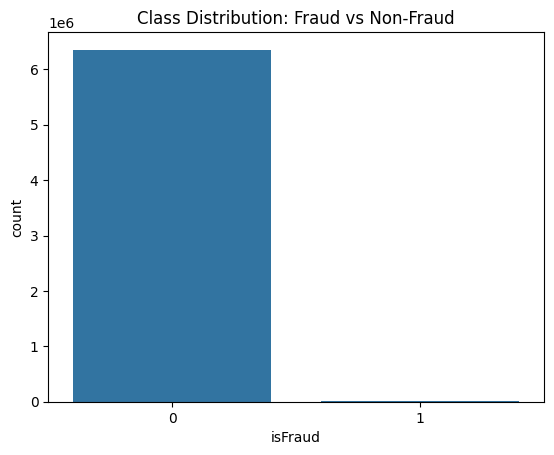

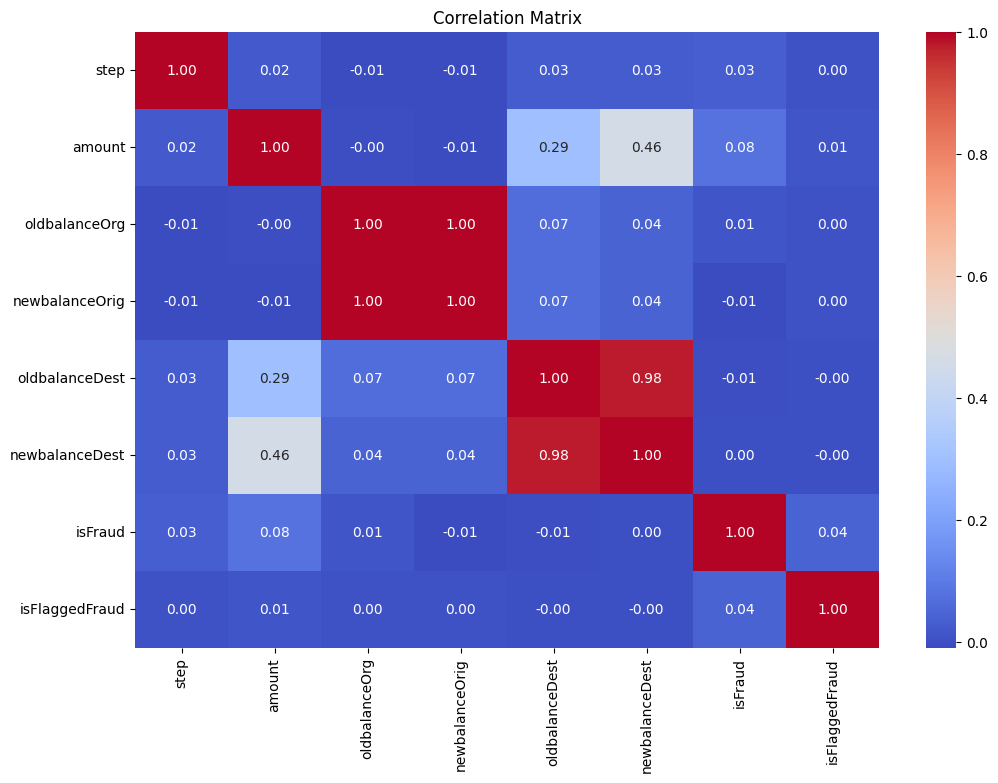

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("PS_20174392719_1491204439457_log.csv")

# Data Information
print(df.info())
print(df.describe())
print("Class distribution:\n", df['isFraud'].value_counts())

# Plot Class Distribution (fraud vs. non-fraud)
sns.countplot(x='isFraud', data=df)
plt.title("Class Distribution: Fraud vs Non-Fraud")
plt.show()

# Plot correlation matrix for numeric features
numeric_cols = df.select_dtypes(include='number').columns
plt.figure(figsize=(12, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


Transaction Type Distribution

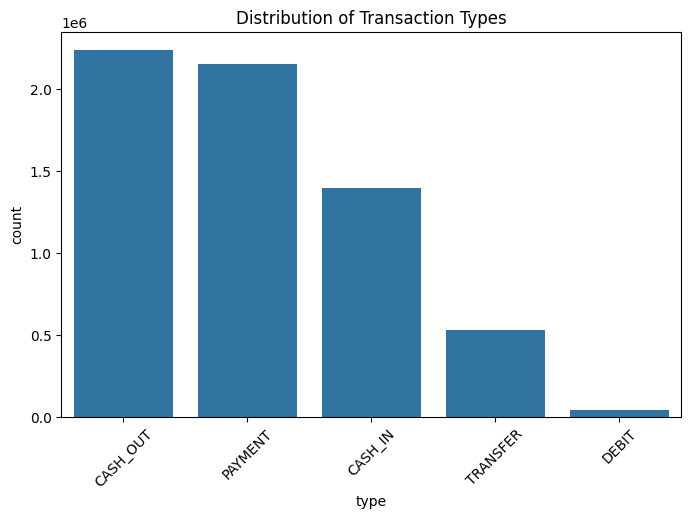

In [2]:
plt.figure(figsize=(8,5))
sns.countplot(x='type', data=df, order=df['type'].value_counts().index)
plt.title("Distribution of Transaction Types")
plt.xticks(rotation=45)
plt.show()


Fraud Rate by Transaction Type

In [3]:
fraud_by_type = df.groupby('type')['isFraud'].mean().sort_values(ascending=False)
print("Fraud Rate by Transaction Type:\n", fraud_by_type)


Fraud Rate by Transaction Type:
 type
TRANSFER    0.007688
CASH_OUT    0.001840
CASH_IN     0.000000
DEBIT       0.000000
PAYMENT     0.000000
Name: isFraud, dtype: float64


Boxplot of Amounts by Fraud

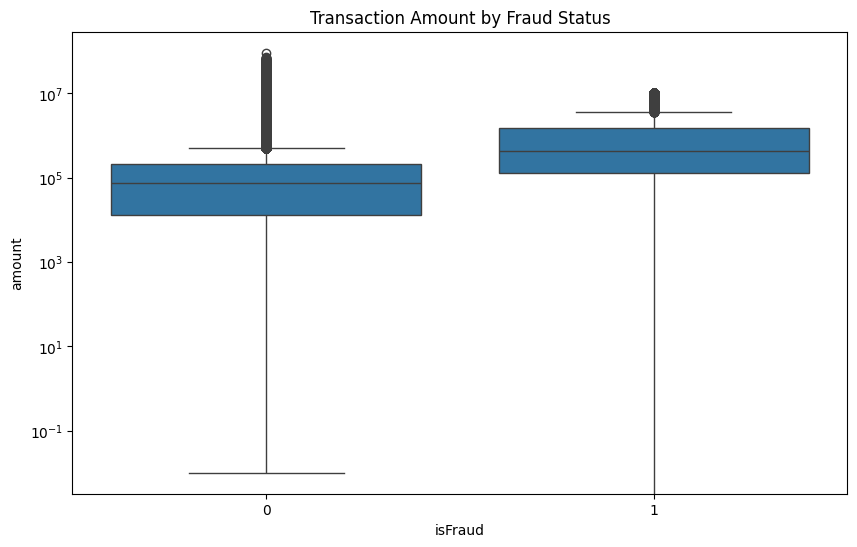

In [4]:
plt.figure(figsize=(10,6))
sns.boxplot(x='isFraud', y='amount', data=df)
plt.yscale('log')  # Because of large range in amount
plt.title("Transaction Amount by Fraud Status")
plt.show()


Outlier Check on Amounts

In [5]:
print("Max transaction amount:", df['amount'].max())
print("Transactions over 10 million:\n", df[df['amount'] > 1e7])


Max transaction amount: 92445516.64
Transactions over 10 million:
          step      type       amount     nameOrig  oldbalanceOrg  \
3591182   262  TRANSFER  23695249.33   C837745698            0.0   
3592661   262  TRANSFER  14291816.93  C1719653359            0.0   
3610921   267  TRANSFER  24288781.97  C1666560485            0.0   
3611293   273  TRANSFER  11376816.99  C1487422082            0.0   
3611622   273  TRANSFER  35797147.01   C292308787            0.0   
...       ...       ...          ...          ...            ...   
6268840   617  TRANSFER  11050732.49  C1946550564            0.0   
6271814   621  TRANSFER  15222880.76    C56090320            0.0   
6273122   630  TRANSFER  11963358.83   C371762975            0.0   
6297147   681  TRANSFER  11368206.77    C75141704            0.0   
6298360   681  TRANSFER  15116218.46   C448900048            0.0   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
3591182             0.0   C81762232

Zero Balances (Often suspicious!)

In [6]:
zero_balances = (df['oldbalanceOrg'] == 0).sum()
print(f"Transactions with zero old balance: {zero_balances}")


Transactions with zero old balance: 2102449


 ## Step 2: Data Cleaning & Feature Engineering

In [7]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Make a copy of the original dataframe
df_cleaned = df.copy()

# -----------------------------------------
# 1. FILTER: Keep only fraud-relevant types
# -----------------------------------------
fraud_types = ['TRANSFER', 'CASH_OUT']
df_cleaned = df_cleaned[df_cleaned['type'].isin(fraud_types)]

# -----------------------------------------
# 2. DROP: Remove non-numeric ID columns
# -----------------------------------------
df_cleaned.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)

# -----------------------------------------
# 3. ENCODE: Convert 'type' to numeric
# -----------------------------------------
le = LabelEncoder()
df_cleaned['type_encoded'] = le.fit_transform(df_cleaned['type'])
df_cleaned.drop('type', axis=1, inplace=True)

# -----------------------------------------
# 4. FEATURE ENGINEERING: Add fraud indicators
# -----------------------------------------

# Balance differences
df_cleaned['balance_diff_orig'] = df_cleaned['oldbalanceOrg'] - df_cleaned['newbalanceOrig']
df_cleaned['balance_diff_dest'] = df_cleaned['newbalanceDest'] - df_cleaned['oldbalanceDest']

# Ratio of amount to original balance
df_cleaned['amount_to_balance_ratio'] = df_cleaned['amount'] / (df_cleaned['oldbalanceOrg'] + 1)

# Flags for zero balances (often suspicious)
df_cleaned['zero_balance_orig'] = (df_cleaned['oldbalanceOrg'] == 0).astype(int)
df_cleaned['zero_balance_dest'] = (df_cleaned['oldbalanceDest'] == 0).astype(int)

# -----------------------------------------
# 5. DROP: Optionally drop 'isFlaggedFraud'
# -----------------------------------------
# It's mostly 0s and not useful for this model
df_cleaned.drop('isFlaggedFraud', axis=1, inplace=True)

# -----------------------------------------
# 6. Final Checks
# -----------------------------------------
print("Final shape of dataset:", df_cleaned.shape)
print("Final columns:", df_cleaned.columns.tolist())
print("Class distribution:\n", df_cleaned['isFraud'].value_counts())

# Optional: Save to CSV
# df_cleaned.to_csv("britcoin_fraud_preprocessed.csv", index=False)


Final shape of dataset: (2770409, 13)
Final columns: ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'type_encoded', 'balance_diff_orig', 'balance_diff_dest', 'amount_to_balance_ratio', 'zero_balance_orig', 'zero_balance_dest']
Class distribution:
 isFraud
0    2762196
1       8213
Name: count, dtype: int64


## Step 3: Train-Test Split & SMOTE

In [8]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# -----------------------------
# 1. Separate features and target
# -----------------------------
X = df_cleaned.drop("isFraud", axis=1)
y = df_cleaned["isFraud"]

# -----------------------------
# 2. Train-test split (stratified to preserve fraud ratio)
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Before SMOTE:\n", y_train.value_counts())

# -----------------------------
# 3. Feature Scaling (recommended for ML models)
# -----------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -----------------------------
# 4. Apply SMOTE to balance classes in training set
# -----------------------------
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print("\nAfter SMOTE:\n", y_train_balanced.value_counts())


Before SMOTE:
 isFraud
0    2209757
1       6570
Name: count, dtype: int64


C:\Users\Leenu Sathidevi\anaconda3\envs\streamlit39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



After SMOTE:
 isFraud
0    2209757
1    2209757
Name: count, dtype: int64


## Step 4: Train & Evaluate Models (Random Forest + XGBoost)

In [9]:
!pip install xgboost

C:\Users\Leenu Sathidevi\anaconda3\envs\streamlit39\lib\site-packages\xgboost\core.py:158: UserWarning: [11:56:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



📊 Random Forest Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552439
           1       0.88      0.99      0.93      1643

    accuracy                           1.00    554082
   macro avg       0.94      1.00      0.97    554082
weighted avg       1.00      1.00      1.00    554082

Confusion Matrix:
[[552219    220]
 [     9   1634]]
ROC AUC Score: 0.997061990723179

📊 XGBoost Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552439
           1       0.49      0.99      0.65      1643

    accuracy                           1.00    554082
   macro avg       0.74      0.99      0.83    554082
weighted avg       1.00      1.00      1.00    554082

Confusion Matrix:
[[550739   1700]
 [    15   1628]]
ROC AUC Score: 0.9938965481350953


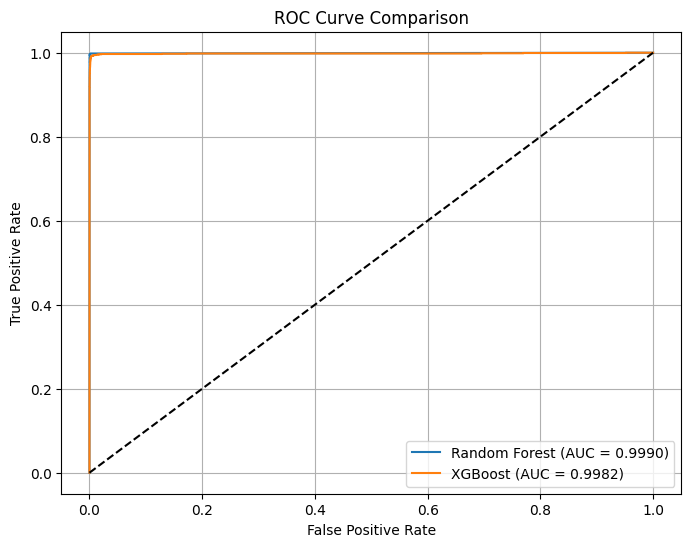

In [10]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. Train Random Forest
# -----------------------------
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_balanced, y_train_balanced)
y_pred_rf = rf.predict(X_test_scaled)

# -----------------------------
# 2. Train XGBoost
# -----------------------------
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_balanced, y_train_balanced)
y_pred_xgb = xgb.predict(X_test_scaled)

# -----------------------------
# 3. Evaluation Function
# -----------------------------
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n📊 {model_name} Classification Report")
    print(classification_report(y_true, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_true, y_pred))

# -----------------------------
# 4. Evaluate Both Models
# -----------------------------
evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_xgb, "XGBoost")

# -----------------------------
# 5. Plot ROC Curve (Optional but Great for Presentation)
# -----------------------------
def plot_roc(model, X_test, y_test, label):
    y_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc_score(y_test, y_probs):.4f})")

plt.figure(figsize=(8, 6))
plot_roc(rf, X_test_scaled, y_test, "Random Forest")
plot_roc(xgb, X_test_scaled, y_test, "XGBoost")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


In [11]:
import pickle

# Save the trained Random Forest model
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf, f)

# Save the fitted scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Model and scaler saved successfully.")


Model and scaler saved successfully.


## Step 5: Model Interpretability

In [12]:
!pip install shap


C:\Users\Leenu Sathidevi\anaconda3\envs\streamlit39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


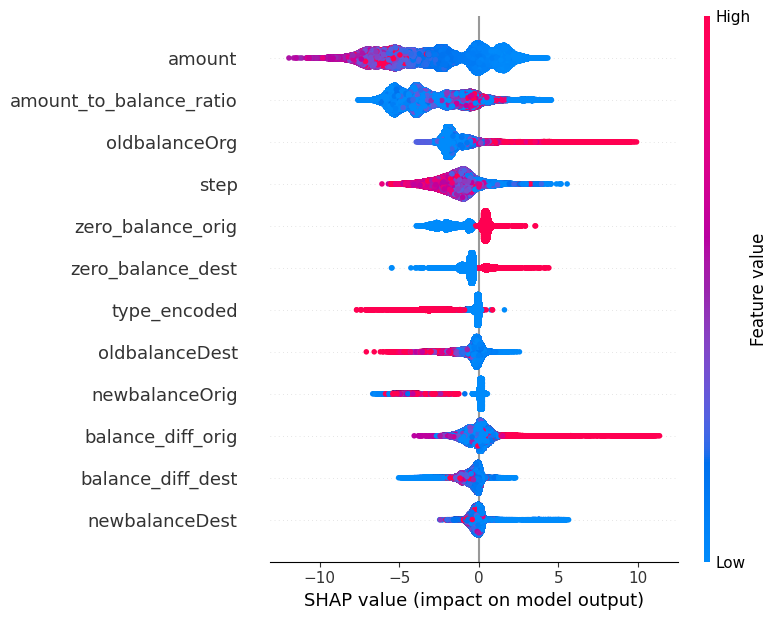

In [13]:
import shap

# Use TreeExplainer for XGBoost
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test_scaled)

# SHAP summary plot (feature importance)
shap.summary_plot(shap_values, X_test, feature_names=X.columns)


In [14]:
# Display the 10th transaction as an example
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[10], X_test.iloc[10])


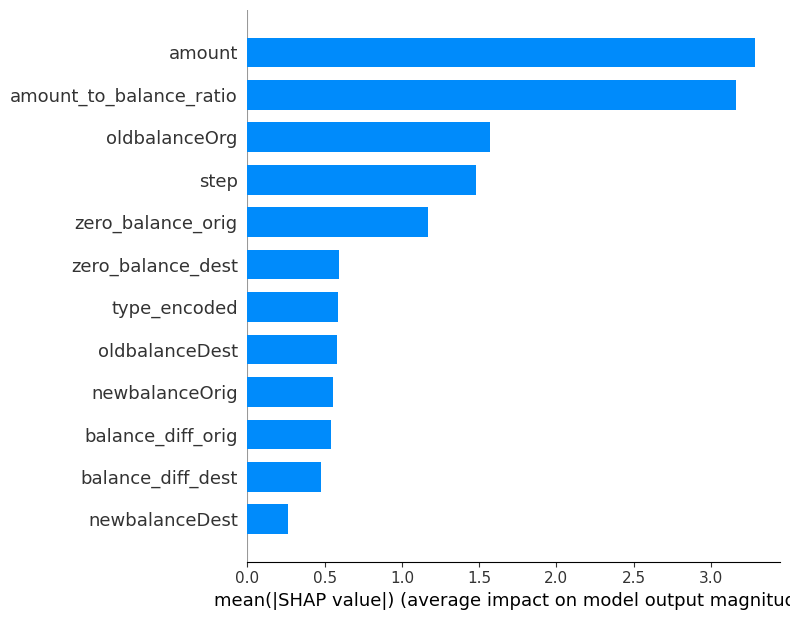

In [15]:
shap.summary_plot(shap_values, X_test, plot_type="bar")


## Blockchain Simulation

In [16]:
import hashlib
import json
import time

class Block:
    def __init__(self, index, timestamp, data, previous_hash):
        self.index = index
        self.timestamp = timestamp
        self.data = data
        self.previous_hash = previous_hash
        self.hash = self.hash_block()

    def hash_block(self):
        block_string = json.dumps(self.__dict__, sort_keys=True).encode()
        return hashlib.sha256(block_string).hexdigest()

class Blockchain:
    def __init__(self):
        self.chain = []
        self.create_genesis_block()

    def create_genesis_block(self):
        genesis_block = Block(0, str(time.time()), "Genesis Block", "0")
        self.chain.append(genesis_block)

    def add_transaction(self, data, is_fraud):
        if is_fraud:
            return "🚫 Fraudulent transaction – not added to the blockchain."
        last_block = self.chain[-1]
        new_block = Block(len(self.chain), str(time.time()), data, last_block.hash)
        self.chain.append(new_block)
        return f" Transaction added. Block #{new_block.index} with Hash: {new_block.hash}"


In [17]:
blockchain = Blockchain()
sample_transaction = {
    "amount": 1200,
    "oldbalanceOrg": 2000,
    "newbalanceOrig": 800,
    "type_encoded": 1  # e.g., TRANSFER
}
fraud_status = 0  # 0 = Not Fraud
result = blockchain.add_transaction(sample_transaction, fraud_status)
print(result)


 Transaction added. Block #1 with Hash: b22a2a4828af6eaa4c66cc83c5ae444049d9664413e477e36c939d4df527a649
